In [14]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [15]:
data_df= pd.read_json('C:/Users/nihal/Downloads/archive (1)/Sarcasm_Headlines_Dataset.json', lines=True)
data_df.dropna(inplace=True)
data_df.drop_duplicates(inplace=True)
data_df.drop(("article_link"), axis=1, inplace=True)
print(f"Dataset shape: {data_df.shape}")
print(data_df.head())


Dataset shape: (26708, 2)
                                            headline  is_sarcastic
0  former versace store clerk sues over secret 'b...             0
1  the 'roseanne' revival catches up to our thorn...             0
2  mom starting to fear son's web series closest ...             1
3  boehner just wants wife to listen, not come up...             1
4  j.k. rowling wishes snape happy birthday in th...             0


In [16]:
X_train,X_test,y_train,y_test= train_test_split(np.array(data_df['headline']), np.array(data_df['is_sarcastic']), test_size=0.3)
X_val,X_test,y_val,y_test= train_test_split(X_test, y_test, test_size=0.5)
print("Training Size: ", X_train.shape[0], "which is ", round(X_train.shape[0]/data_df.shape[0],4)*100, "% of total data")
print("Validation Size: ", X_val.shape[0], "which is ", round(X_val.shape[0]/data_df.shape[0],4)*100, "% of total data")
print("Testing Size: ", X_test.shape[0], "which is ", round(X_test.shape[0]/data_df.shape[0],4)*100, "% of total data")

Training Size:  18695 which is  70.0 % of total data
Validation Size:  4006 which is  15.0 % of total data
Testing Size:  4007 which is  15.0 % of total data


In [17]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

In [18]:
class dataset(Dataset):
    def __init__(self,X,Y):
        self.X = [tokenizer(X,
                  max_length=100,
                  padding='max_length',
                  return_tensors='pt',).to(device) 
                  for X in X
        ]
        self.Y=torch.tensor(Y,dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        return self.X[idx], self.Y[idx]
    
train_dataset= dataset(X_train,y_train)
val_dataset= dataset(X_val,y_val)   
test_dataset= dataset(X_test,y_test)

In [19]:
BATCH_SIZE=32
EPOCHS=15
LR=0.001

In [20]:
train_dataloader= DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader= DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader= DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
class SarcasmModel(nn.Module):
    def __init__(self, bert):
        super(SarcasmModel,self).__init__()   

        self.bert= bert
        self.dropout= nn.Dropout(0.25)
        self.linear1= nn.Linear(768,384)
        self.linear2= nn.Linear(384,1)
        self.sigmoid= nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        pooled_output= self.bert(input_ids, attention_mask, return_dict=False)[0][:,0]
        output = self.linear1(pooled_output)
        output = self.dropout(output)
        output = self.linear2(output)
        output = self.sigmoid(output)
        return output

In [22]:
for param in bert_model.parameters():
    param.requires_grad = False

model= SarcasmModel(bert_model).to(device)

In [23]:
model

SarcasmModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [24]:
criterion= nn.BCELoss()
optimizer= Adam(model.parameters(), lr=LR)

In [27]:
total_loss_train_plot=[]
total_loss_val_plot=[]
total_acc_val_plot=[]
total_acc_train_plot=[]

for epoch in range(EPOCHS):
    total_acc_train=0
    total_loss_train=0
    total_acc_val=0
    total_loss_val=0
    
    for indx,data in enumerate(train_dataloader):
        inputs, labels= data
        inputs.to(device)
        labels.to(device)

        predictions= model(inputs['input_ids'].squeeze(1), inputs['attention_mask'].squeeze(1)).squeeze(1)
        batch_loss= criterion(predictions, labels)
        total_loss_train+= batch_loss.item()

        acc=(predictions.round()==labels).sum().item()
        total_acc_train+= acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for indx,data in enumerate(val_dataloader):
            inputs, labels= data
            inputs.to(device)
            labels.to(device)

            predictions= model(inputs['input_ids'].squeeze(1), inputs['attention_mask'].squeeze(1)).squeeze(1)
            batch_loss= criterion(predictions, labels)
            total_loss_val+= batch_loss.item()

            acc=(predictions.round()==labels).sum().item()
            total_acc_val+= acc
    total_loss_train_plot.append(total_loss_train/len(train_dataloader))
    total_acc_train_plot.append(total_acc_train/X_train.shape[0])
    total_loss_val_plot.append(total_loss_val/len(val_dataloader))
    total_acc_val_plot.append(total_acc_val/X_val.shape[0])

    print(f"Epoch {epoch+1}/{EPOCHS} "
          f"| Train Loss: {total_loss_train/len(train_dataloader)}, Acc: {total_acc_train/X_train.shape[0]} "
          f"| Val Loss: {total_loss_val/len(val_dataloader)}, Acc: {total_acc_val/X_val.shape[0]}")

Epoch 1/15 | Train Loss: 0.3055313918325636, Acc: 0.8693233484889008 | Val Loss: 0.32907724587453735, Acc: 0.8622066899650525
Epoch 2/15 | Train Loss: 0.304421045179041, Acc: 0.8709815458678791 | Val Loss: 0.32494844247897464, Acc: 0.8609585621567648
Epoch 3/15 | Train Loss: 0.3041988821111174, Acc: 0.8705001337255951 | Val Loss: 0.3305852245243769, Acc: 0.8589615576635048
Epoch 4/15 | Train Loss: 0.3039891546862757, Acc: 0.8716769189622894 | Val Loss: 0.320499693472234, Acc: 0.8637044433349975
Epoch 5/15 | Train Loss: 0.3022120265624462, Acc: 0.8701791922974057 | Val Loss: 0.3203949471787801, Acc: 0.8604593110334499
Epoch 6/15 | Train Loss: 0.3031126875271145, Acc: 0.870874565391816 | Val Loss: 0.3816648912689989, Acc: 0.8277583624563155
Epoch 7/15 | Train Loss: 0.30357886923429295, Acc: 0.8702861727734689 | Val Loss: 0.32378807238170076, Acc: 0.8627059410883674
Epoch 8/15 | Train Loss: 0.3035273391339514, Acc: 0.8692698582508692 | Val Loss: 0.32042702393872396, Acc: 0.86345481777334


In [28]:
with torch.no_grad():
    total_loss_test=0
    total_acc_test=0

    for indx,data in enumerate(test_dataloader):
            inputs, labels= data
            inputs.to(device)
            labels.to(device)

            predictions= model(inputs['input_ids'].squeeze(1), inputs['attention_mask'].squeeze(1)).squeeze(1)
            batch_loss= criterion(predictions, labels)
            total_loss_test+= batch_loss.item()

            acc=(predictions.round()==labels).sum().item()
            total_acc_test+= acc
    print(f"Accuray Score on test data is :{round(total_acc_test/X_test.shape[0])}")

Accuray Score on test data is :1


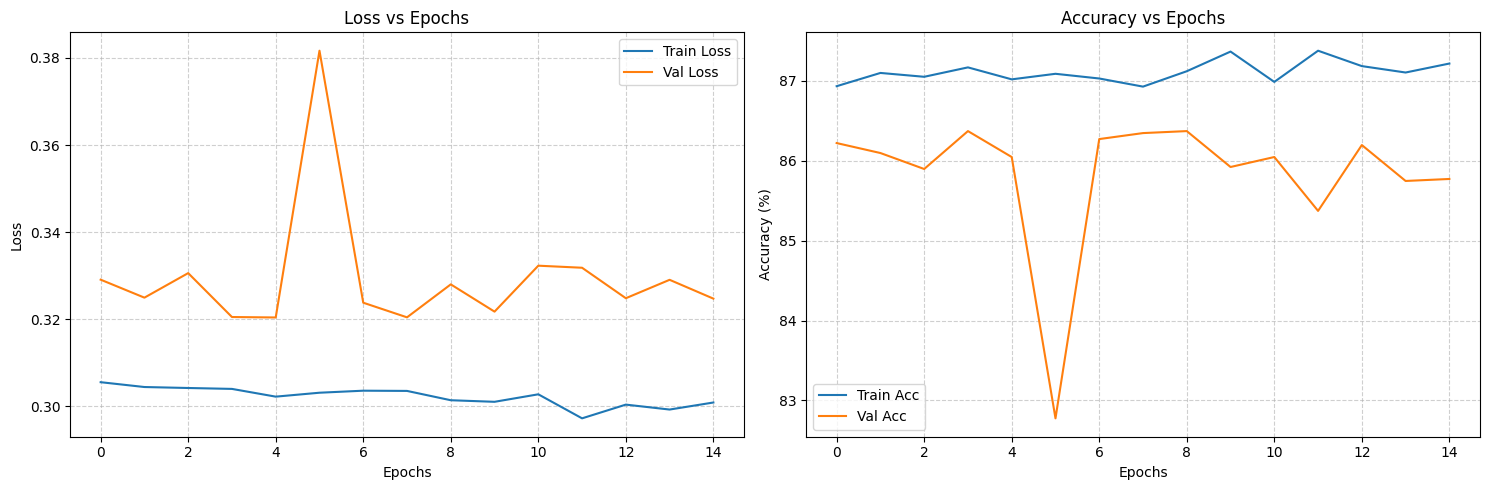

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

# Loss plot
axs[0].plot(total_loss_train_plot, label='Train Loss')
axs[0].plot(total_loss_val_plot, label='Val Loss')
axs[0].set_title("Loss vs Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].grid(True, linestyle="--", alpha=0.6)
axs[0].legend()

# Accuracy plot
axs[1].plot([a*100 for a in total_acc_train_plot], label='Train Acc')
axs[1].plot([a*100 for a in total_acc_val_plot], label='Val Acc')
axs[1].set_title("Accuracy vs Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy (%)")
axs[1].grid(True, linestyle="--", alpha=0.6)
axs[1].legend()

plt.tight_layout()
plt.show()
